# Refactored simple nets

In [10]:
from setup import *
from generators import * 
from utils import *
from denoising_unet import *

/home/faster/anaconda3/envs/tf/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from keras import layers
import io
import cv2
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox
from keras import backend as K


In [14]:
tf.__version__

'2.15.0'

In [3]:
batch_size = 32

In [4]:
high_path_2010_2019 = "data/wind_speed_italy_CERRA_2010-2019.npy"
high_path_2020 = "data/wind_speed_italy_CERRA_2020.npy"
high_path_2009 = "data/wind_speed_italy_CERRA_2009.npy"
high_path_balcans = "data/wind_speed_BALCANS_CERRA_2009.npy"


low_path_2010_2019 = "data/wind_speed_italy_ERA5_2010-2019.npy"
low_path_2020 = "data/wind_speed_italy_ERA5_2020.npy"
low_path_2009 = "data/wind_speed_italy_ERA5_2009.npy"
low_path_balcans = "data/wind_speed_BALCANS_ERA5_2009.npy"

In [5]:
train_generator = lowResDataGeneratorMemmap(high_path_2010_2019,low_path_2010_2019, 
                                      setup.max_high_res, setup.max_low_res, 
                                      setup.dataset_lenght_2010_2019,sequential=False,
                                      batch_size = batch_size, unet = True)

test_generator = lowResDataGeneratorMemmap(high_path_2020,low_path_2020, 
                                      setup.max_high_res, setup.max_low_res, 
                                      setup.dataset_lenght_2020,sequential=False,
                                      batch_size = batch_size, unet = True)

full_test_generator = lowResDataGeneratorMemmap(high_path_2020,low_path_2020, 
                                      setup.max_high_res, setup.max_low_res, 
                                      setup.dataset_lenght_2020,sequential=True,
                                      batch_size = batch_size, unet = True)

full_test_generator2009 = lowResDataGeneratorMemmap(high_path_2009,low_path_2009, 
                                      setup.max_high_res, setup.max_low_res, 
                                      setup.dataset_lenght_2009,sequential=True,
                                      batch_size = batch_size, unet = True)

full_test_generatorBALCANS = lowResDataGeneratorMemmap(high_path_balcans,low_path_balcans, 
                                      setup.max_high_res, setup.max_low_res, 
                                      setup.dataset_lenght_2009,sequential=True,
                                      batch_size = batch_size, unet = True)

### Training

In [6]:
def get_espcnn_Deconv(upscale_factor=4, channels=4):
    conv_args = {
        "activation": "relu",
        "kernel_initializer": "Orthogonal",
        "padding": "same",
    }
    inputs = keras.Input(shape=(52, 52, channels))
    
    x = layers.Conv2DTranspose(128, (13, 13), strides=(1, 1), padding='valid', activation='swish', input_shape=(52, 52, 1))(inputs)
    
    x = layers.Conv2D(128, 5, **conv_args)(x)
    x = layers.Conv2D(128, 3, **conv_args)(x)
    x = layers.Conv2D(64, 3, **conv_args)(x)
    x = layers.Conv2D(1 * (upscale_factor ** 2), 3, **conv_args)(x)
    outputs = tf.nn.depth_to_space(x, upscale_factor)

    return keras.Model(inputs, outputs)

In [7]:
espcnn_model = get_espcnn_Deconv()

optimizer=keras.optimizers.experimental.AdamW
espcnn_model.compile(
    optimizer=optimizer(
        learning_rate=1e-4, weight_decay=1e-5
    ),
    loss=tf.keras.losses.MeanSquaredError()
)

2024-01-09 12:33:58.877650: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-09 12:33:58.889053: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-09 12:33:58.889472: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-09 12:33:58.890106: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other 

In [8]:
espcnn_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 52, 52, 4)]       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 64, 64, 128)      86656     
 nspose)                                                         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 128)       409728    
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       147584    
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        73792     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 16)        9232      
                                                             

In [9]:
# def post_saver(epoch, logs):
#     if(epoch % 10 == 0):
#         unet_model.save_weights("weights/"+str(epoch)+"unet")

In [10]:
#unet_model.load_weights("weights/110unet")

In [11]:
a, b = train_generator.__getitem__(1)

In [12]:
a.shape

(32, 52, 52, 4)

In [13]:
espcnn_model.load_weights("./weights/escpn_model")

In [99]:
# run training and plot generated images periodically
espcnn_model.fit(
    train_generator,
    #initial_epoch = 100, 
    #validation_data = valid_generator, 
    epochs=10,
    steps_per_epoch=500,
    #batch_size=32,
    #callbacks=[
        #keras.callbacks.LambdaCallback(on_epoch_end=post_saver)
    #],
)

Epoch 1/10
500/500 [==============================] - 17s 34ms/step - loss: 0.0013
Epoch 2/10
500/500 [==============================] - 17s 34ms/step - loss: 0.0013
Epoch 3/10
500/500 [==============================] - 17s 34ms/step - loss: 0.0013
Epoch 4/10
500/500 [==============================] - 17s 34ms/step - loss: 0.0013
Epoch 5/10
500/500 [==============================] - 17s 35ms/step - loss: 0.0012
Epoch 6/10
500/500 [==============================] - 18s 35ms/step - loss: 0.0012
Epoch 7/10
500/500 [==============================] - 18s 36ms/step - loss: 0.0012
Epoch 8/10
500/500 [==============================] - 18s 35ms/step - loss: 0.0012
Epoch 9/10
500/500 [==============================] - 17s 35ms/step - loss: 0.0012
Epoch 10/10
500/500 [==============================] - 17s 35ms/step - loss: 0.0012



## Visual evaluation

In [14]:
np.random.seed(10)
sampin,sampout = test_generator.__getitem__(1)
tmp = espcnn_model.predict(sampin)

2024-01-08 14:16:58.412947: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8800


1/1 [==============================] - 1s 1s/step


2024-01-08 14:16:58.825817: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-08 14:16:58.826144: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-08 14:16:58.826159: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:85] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2024-01-08 14:16:58.826451: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-08 14:16:58.826469: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:318] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


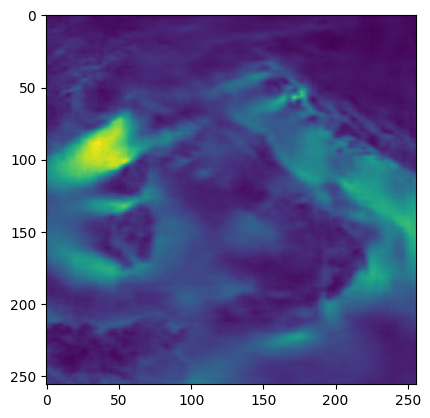

In [15]:
plt.imshow(tmp[4])

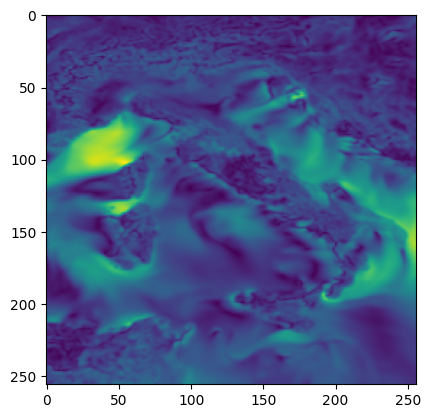

In [16]:
plt.imshow(sampout[4])

In [18]:
def print_results_unet(a,b,c):
    
    for i in range(a.shape[0]):
        fig, axes = plt.subplots(1, 3, figsize=(15, 5.5))
        
        ax = axes[0]
        ax.imshow(a[i,:,:,-1], cmap='viridis')  # Use appropriate colormap for your data
        ax.axis('off')
        ax.set_title("last low res")
        
        ax = axes[1]
        ax.imshow(c[i,:,:], cmap='viridis')  # Use appropriate colormap for your data
        ax.axis('off')
        ax.set_title("predicted")

        ax = axes[2]
        ax.imshow(b[i,:,:], cmap='viridis')  # Use appropriate colormap for your data
        ax.axis('off')
        ax.set_title("ground truth")       

        plt.tight_layout()
        #plt.savefig("unet" + str(i) + ".png")
        plt.show()
        

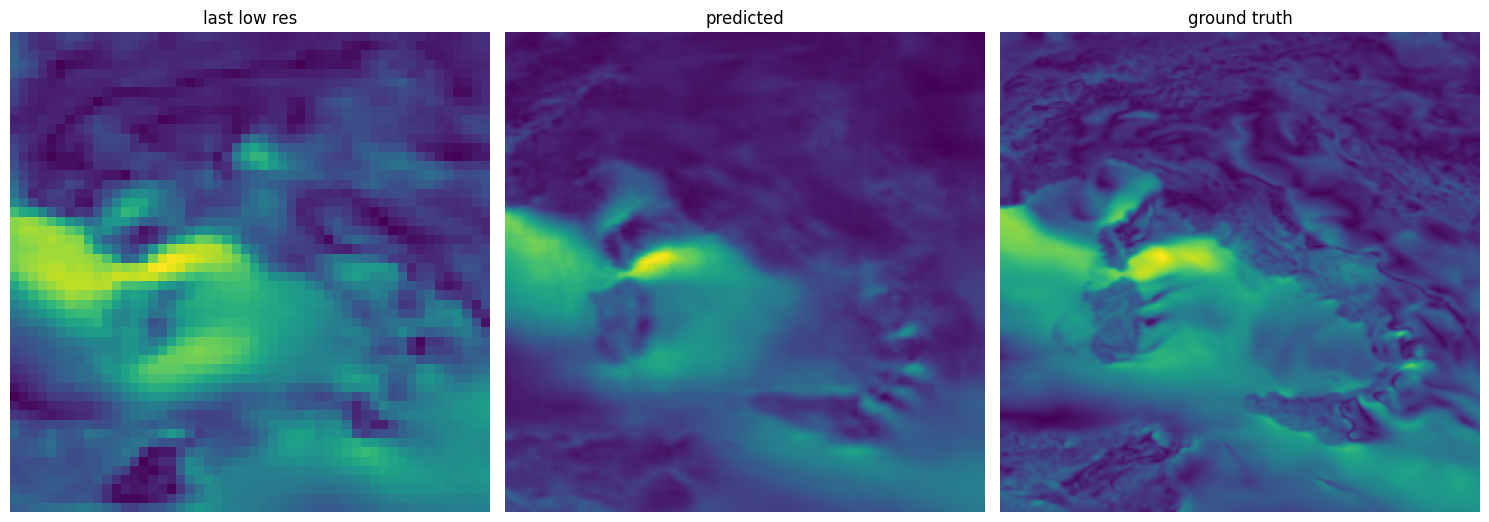

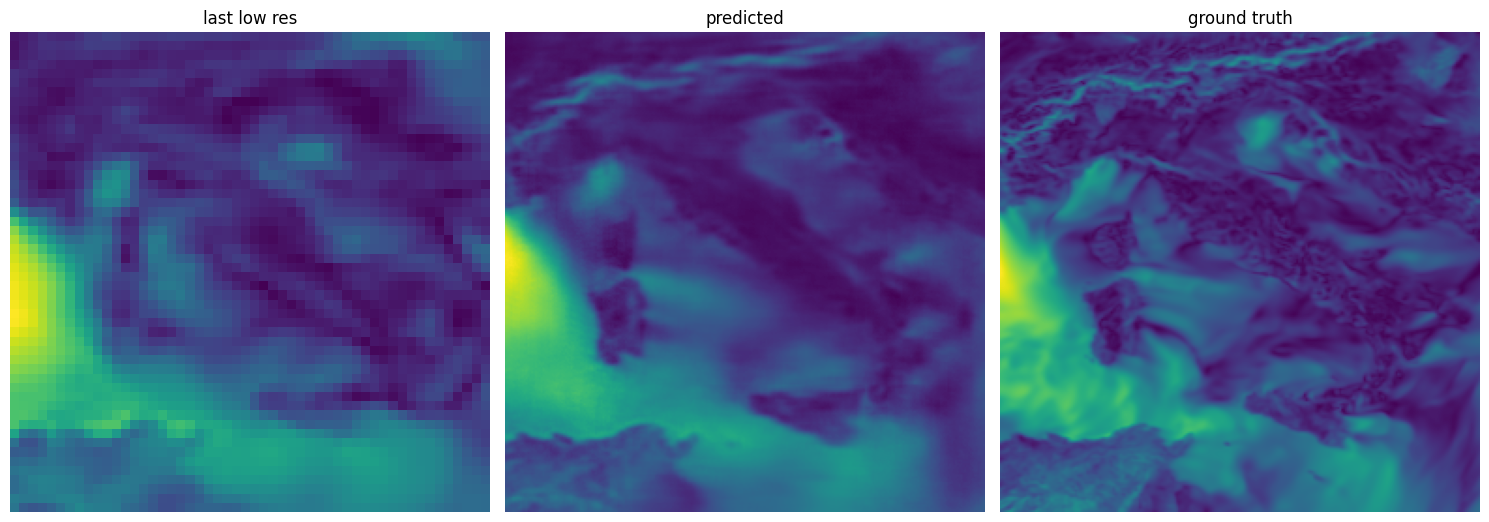

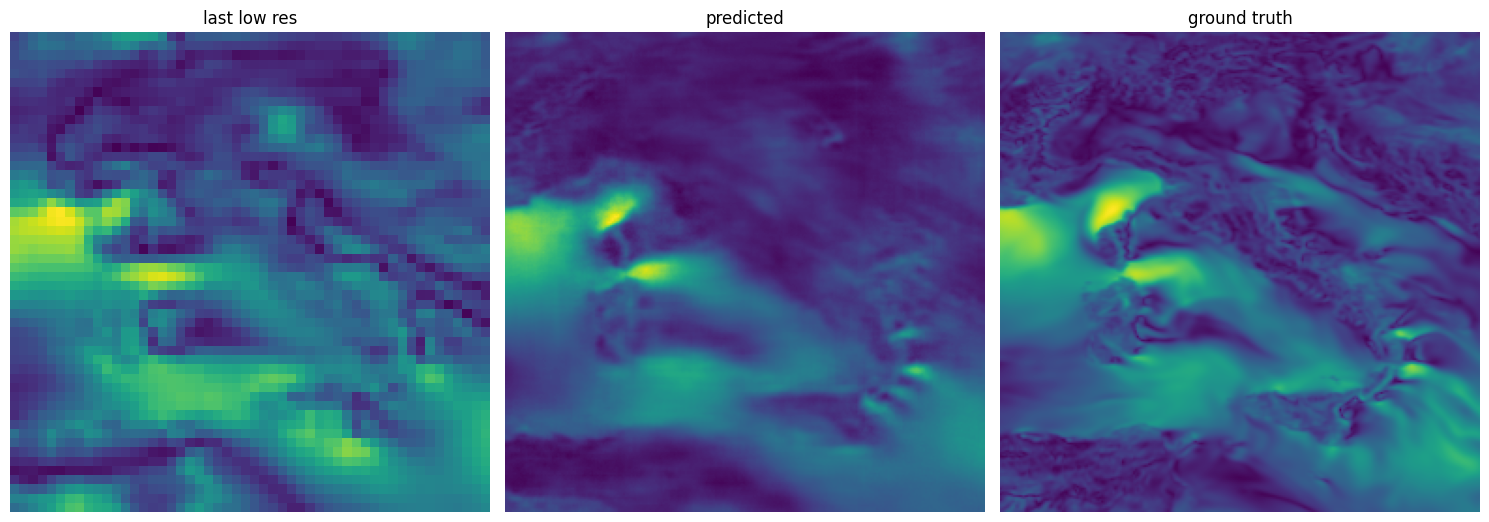

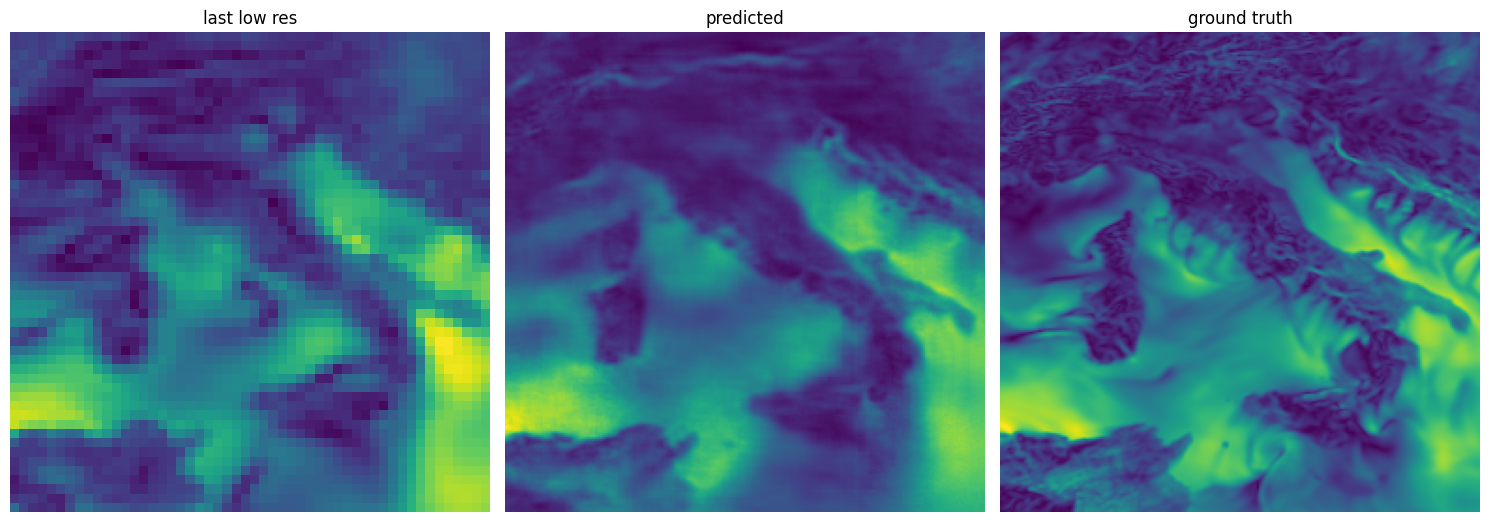

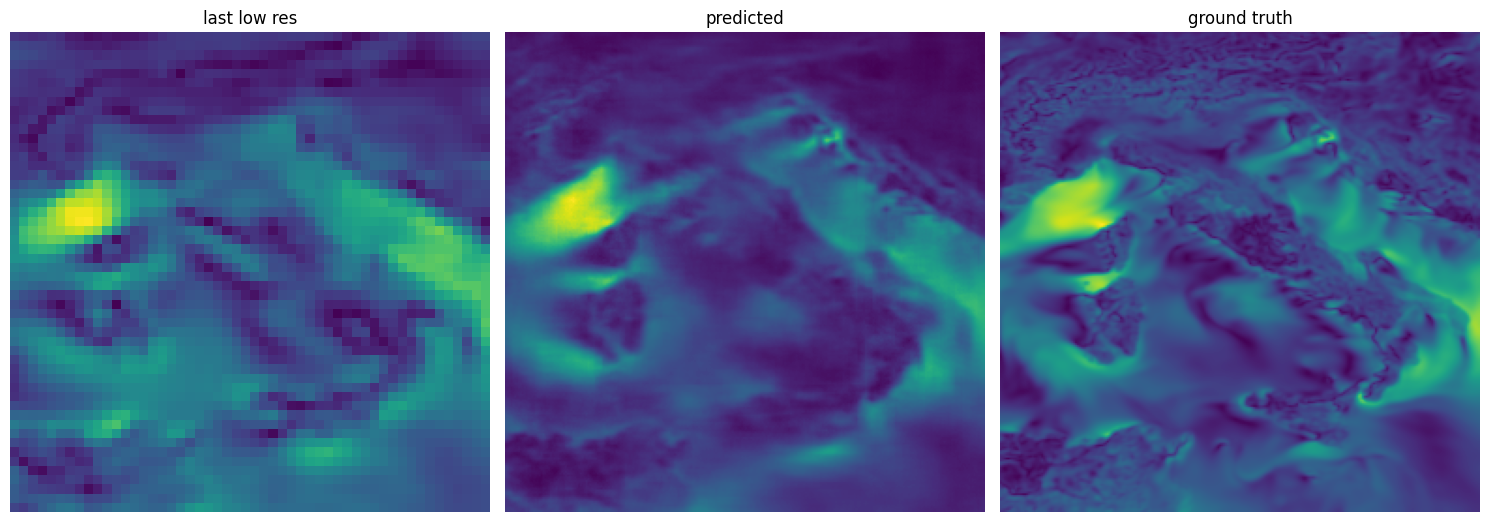

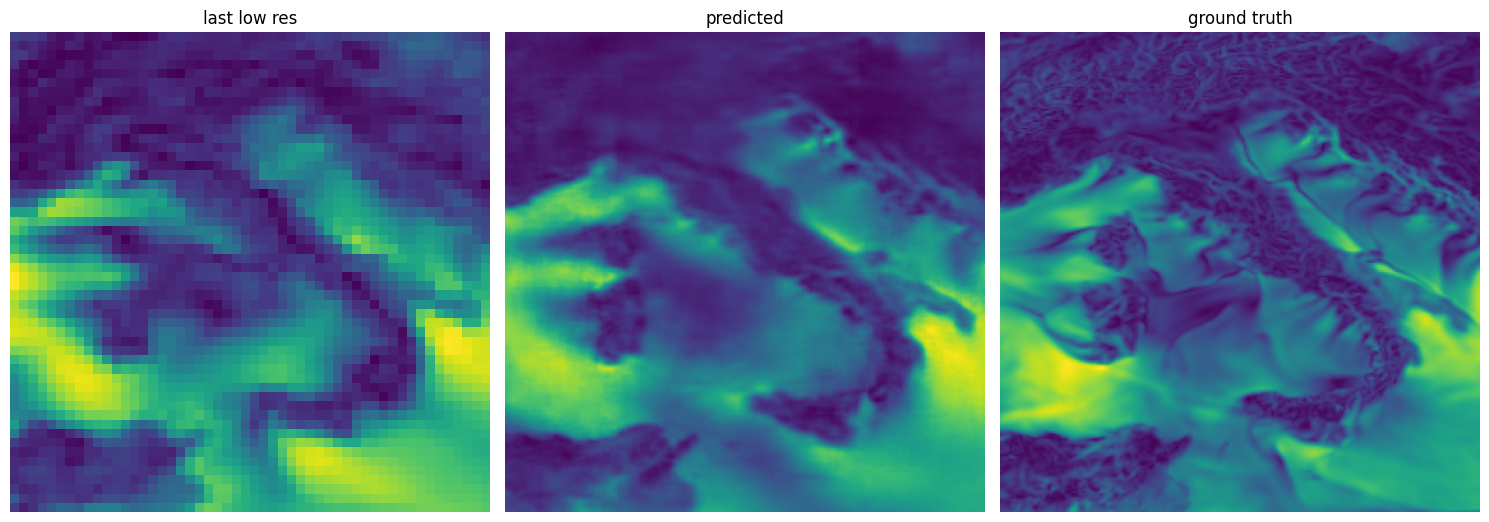

In [19]:
print_results_unet(sampin,sampout,tmp)

In [20]:
#np.save("./visualization_recap_data/espcn",tmp)

## Evaluation

In [21]:
def experiment_espcn(generator, n_iter=100):
    #define final mse array 
    #raw = np.zeros((91,32,256,256))
    #bilinear = np.zeros((91,32,256,256))
    mses = np.zeros(n_iter)
    mses_baseline = np.zeros(n_iter)
    
    ssims = np.zeros(n_iter)
    psnrs = np.zeros(n_iter)
    
    ssims_baseline = np.zeros(n_iter)
    psnrs_baseline = np.zeros(n_iter)
    for i in range(n_iter):
        if(i%5 == 0):
            print(i)
        #select a random batch in the test set  
        sampin,sampout = generator.__getitem__(i)
        
        tmp = espcnn_model.predict(sampin)
        
        sampin2 = np.zeros((sampin.shape[0],256,256,4))
        for l in range(sampin.shape[0]):
            for m in range(4):
                sampin2[l,:,:,m] = cv2.resize(sampin[l,:,:,m],(256,256),interpolation=cv2.INTER_LINEAR)
        sampin = sampin2
        
        mse = np.mean( ((sampout-np.squeeze(tmp))**2))
        ssims[i] = batch_ssim(sampout,np.squeeze(tmp))
        psnrs[i] = batch_psnr(sampout,np.squeeze(tmp))
        
        mse_baseline = np.mean( ((sampin[:,:,:,-2]-sampout)**2))
        ssims_baseline[i] = batch_ssim(sampin[:,:,:,-2],sampout)
        psnrs_baseline[i] = batch_psnr(sampin[:,:,:,-2],sampout)
        #print(mse.shape)
        # add 3 relevant meteric values to array 
        mses_baseline[i] = mse_baseline
        mses[i] = mse
        #raw[i] = np.squeeze(tmp)
        #bilinear[i] = sampin[:,:,:,-2]
    # return average of all mses
    return mses, mses_baseline, psnrs, psnrs_baseline, ssims, ssims_baseline#, raw, bilinear

In [22]:
import time
full_test_generator2009.counter_reset()
start_time = time.time()  # Capture the start time
mses, mses_baseline, psnrs, psnrs_baseline, ssims, ssims_baseline = experiment_espcn(full_test_generator2009,91)
end_time = time.time()  # Capture the end time
execution_time = end_time - start_time 

0
1/1 [==============================] - 0s 14ms/step
5
1/1 [==============================] - 0s 14ms/step
10
1/1 [==============================] - 0s 10ms/step
15
1/1 [==============================] - 0s 10ms/step
20
1/1 [==============================] - 0s 10ms/step
25
1/1 [==============================] - 0s 10ms/step
30
1/1 [==============================] - 0s 10ms/step
35
1/1 [==============================] - 0s 10ms/step
40
1/1 [==============================] - 0s 10ms/step
45
1/1 [==============================] - 0s 10ms/step
50
1/1 [==============================] - 0s 10ms/step
55
1/1 [==============================] - 0s 10ms/step
60
1/1 [==============================] - 0s 14ms/step
65
1/1 [==============================] - 0s 14ms/step
70
1/1 [==============================] - 0s 10ms/step
75
1/1 [==============================] - 0s 10ms/step
80
1/1 [==============================] - 0s 10ms/step
85
1/1 [==============================] - 0s 10ms/step
90
1/1 [====

In [27]:
np.save("./raw/raw2009espcnn", raw)

In [19]:
execution_time

23.819735527038574

In [17]:
print("ssim:", ssims.mean(), "  ssim baseline:", ssims_baseline.mean())

print("psnrs:", psnrs.mean(), "  psnrs_baseline:", psnrs_baseline.mean())

print("mse:", mses.mean(), "  mse baseline:", mses_baseline.mean())

ssim: 0.7736444446816015   ssim baseline: 0.7080940925770614
psnrs: 29.11138287520316   psnrs_baseline: 26.36268835909181
mse: 0.0013090540852079776   mse baseline: 0.002566588443630148


In [95]:
print("ssim:", ssims.mean(), "  ssim baseline:", ssims_baseline.mean())

print("psnrs:", psnrs.mean(), "  psnrs_baseline:", psnrs_baseline.mean())

print("mse:", mses.mean(), "  mse baseline:", mses_baseline.mean())

ssim: 0.775600035027492   ssim baseline: 0.7120680397710939
psnrs: 29.314610085181798   psnrs_baseline: 26.678920945932934
mse: 0.0012571999640123156   mse baseline: 0.002385194862603757


In [98]:
np.save("numerical_results/espcn2020_mses",mses)
#np.save("numerical_results/baseline2020_mses",mses_baseline)

np.save("numerical_results/espcn2020_psnrs",psnrs)
#np.save("numerical_results/baseline2020_psnrs",psnrs_baseline)

np.save("numerical_results/espcn2020_ssims",ssims)
#np.save("numerical_results/baseline2020_ssims",ssims_baseline)

## EDSR

In [28]:
# Residual Block
def ResBlock(inputs):
    x = layers.Conv2D(128, 3, padding="same", activation="relu")(inputs)
    x = layers.Conv2D(128, 3, padding="same")(x)
    x = layers.Add()([inputs, x])
    return x


# Upsampling Block
def Upsampling(inputs, factor=2, **kwargs):
    x = layers.Conv2D(64 * (factor ** 2), 3, padding="same", **kwargs)(inputs)
    x = tf.nn.depth_to_space(x, block_size=factor)
    x = layers.Conv2D(64 * (factor ** 2), 3, padding="same", **kwargs)(x)
    x = tf.nn.depth_to_space(x, block_size=factor)
    return x


def get_EDSR(num_filters, num_of_residual_blocks):
    # Flexible Inputs to input_layer
    input_layer = layers.Input(shape=(52, 52, 4))
    x = layers.Conv2DTranspose(128, (13, 13), strides=(1, 1), padding='valid', activation='swish', input_shape=(52, 52, 1))(input_layer)
    x = x_new = layers.Conv2D(num_filters, 3, padding="same")(x)

    # 16 residual blocks
    for _ in range(num_of_residual_blocks):
        x_new = ResBlock(x_new)

    x_new = layers.Conv2D(num_filters, 1, padding="same")(x_new)
    x = layers.Add()([x, x_new])

    x = Upsampling(x)
    x = layers.Conv2D(1, 3, padding="same")(x)

    
    return keras.Model(input_layer, x)

In [29]:
EDSR_model = get_EDSR(128,5)

optimizer=keras.optimizers.experimental.AdamW
EDSR_model.compile(
    optimizer=optimizer(
        learning_rate=1e-4, weight_decay=1e-5
    ),
    loss=tf.keras.losses.MeanSquaredError()
)

In [30]:
EDSR_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 52, 52, 4)]  0           []                               
                                                                                                  
 conv2d_transpose_1 (Conv2DTran  (None, 64, 64, 128)  86656      ['input_2[0][0]']                
 spose)                                                                                           
                                                                                                  
 conv2d_4 (Conv2D)              (None, 64, 64, 128)  147584      ['conv2d_transpose_1[0][0]']     
                                                                                                  
 conv2d_5 (Conv2D)              (None, 64, 64, 128)  147584      ['conv2d_4[0][0]']         

In [31]:
# run training and plot generated images periodically
EDSR_model.fit(
    train_generator,
    #validation_data = valid_generator, 
    epochs=20,
    steps_per_epoch=500,
    #batch_size=32,
    callbacks=[
        #reduce_lr_unet,
        #keras.callbacks.LambdaCallback(on_epoch_end=post_saver)
    ],
)

Epoch 1/20


2024-01-09 13:53:35.105078: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x26639530 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-09 13:53:35.105101: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA RTX A4000, Compute Capability 8.6
2024-01-09 13:53:35.108359: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-09 13:53:35.122891: W tensorflow/compiler/xla/service/gpu/nvptx_helper.cc:56] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This may result in compilation or runtime failures, if the program we try to run uses routines from libdevice.
Searched for CUDA in the following directories:
  ./cuda_sdk_lib
  /usr/local/cuda-11.2
  /usr/local/cuda
  .
You can choose the search directory by setting xla_gpu_cuda_data_dir in HloModule's DebugOptions.  For most apps

InternalError: Graph execution error:

Detected at node 'StatefulPartitionedCall_31' defined at (most recent call last):
    File "/home/faster/anaconda3/envs/tf11/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/faster/anaconda3/envs/tf11/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/home/faster/anaconda3/envs/tf11/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/faster/anaconda3/envs/tf11/lib/python3.10/site-packages/traitlets/config/application.py", line 992, in launch_instance
      app.start()
    File "/home/faster/anaconda3/envs/tf11/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 736, in start
      self.io_loop.start()
    File "/home/faster/anaconda3/envs/tf11/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/home/faster/anaconda3/envs/tf11/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/home/faster/anaconda3/envs/tf11/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
      handle._run()
    File "/home/faster/anaconda3/envs/tf11/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/faster/anaconda3/envs/tf11/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "/home/faster/anaconda3/envs/tf11/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "/home/faster/anaconda3/envs/tf11/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 412, in dispatch_shell
      await result
    File "/home/faster/anaconda3/envs/tf11/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "/home/faster/anaconda3/envs/tf11/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/home/faster/anaconda3/envs/tf11/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/faster/anaconda3/envs/tf11/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3024, in run_cell
      result = self._run_cell(
    File "/home/faster/anaconda3/envs/tf11/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3079, in _run_cell
      result = runner(coro)
    File "/home/faster/anaconda3/envs/tf11/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/faster/anaconda3/envs/tf11/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3284, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/faster/anaconda3/envs/tf11/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3466, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/faster/anaconda3/envs/tf11/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_219068/398364480.py", line 2, in <module>
      EDSR_model.fit(
    File "/home/faster/anaconda3/envs/tf11/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/faster/anaconda3/envs/tf11/lib/python3.10/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/faster/anaconda3/envs/tf11/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/home/faster/anaconda3/envs/tf11/lib/python3.10/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/faster/anaconda3/envs/tf11/lib/python3.10/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/home/faster/anaconda3/envs/tf11/lib/python3.10/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/home/faster/anaconda3/envs/tf11/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/home/faster/anaconda3/envs/tf11/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/home/faster/anaconda3/envs/tf11/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/home/faster/anaconda3/envs/tf11/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/home/faster/anaconda3/envs/tf11/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/home/faster/anaconda3/envs/tf11/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_31'
libdevice not found at ./libdevice.10.bc
	 [[{{node StatefulPartitionedCall_31}}]] [Op:__inference_train_function_24952]

In [38]:
EDSR_model.load_weights("EDSR_200epochs")

In [43]:
def experiment_edsr(generator, n_iter=100):
    #define final mse array 
    #raw = np.zeros((91,32,256,256))
    #bilinear = np.zeros((91,32,256,256))
    mses = np.zeros(n_iter)
    mses_baseline = np.zeros(n_iter)
    
    ssims = np.zeros(n_iter)
    psnrs = np.zeros(n_iter)
    
    ssims_baseline = np.zeros(n_iter)
    psnrs_baseline = np.zeros(n_iter)
    for i in range(n_iter):
        if(i%5 == 0):
            print(i)
        #select a random batch in the test set  
        sampin,sampout = generator.__getitem__(i)
        
        tmp = EDSR_model.predict(sampin)
        
        sampin2 = np.zeros((sampin.shape[0],256,256,4))
        for l in range(sampin.shape[0]):
            for m in range(4):
                sampin2[l,:,:,m] = cv2.resize(sampin[l,:,:,m],(256,256),interpolation=cv2.INTER_LINEAR)
        sampin = sampin2
        
        mse = np.mean( ((sampout-np.squeeze(tmp))**2))
        ssims[i] = batch_ssim(sampout,np.squeeze(tmp))
        psnrs[i] = batch_psnr(sampout,np.squeeze(tmp))
        
        mse_baseline = np.mean( ((sampin[:,:,:,-2]-sampout)**2))
        ssims_baseline[i] = batch_ssim(sampin[:,:,:,-2],sampout)
        psnrs_baseline[i] = batch_psnr(sampin[:,:,:,-2],sampout)
        #print(mse.shape)
        # add 3 relevant meteric values to array 
        mses_baseline[i] = mse_baseline
        mses[i] = mse
        #raw[i] = np.squeeze(tmp)
        #bilinear[i] = sampin[:,:,:,-2]
    # return average of all mses
    return mses, mses_baseline, psnrs, psnrs_baseline, ssims, ssims_baseline#, raw#, raw, bilinear

In [40]:
import time
full_test_generator.counter_reset()
start_time = time.time()  # Capture the start time

full_test_generator2009.counter_reset()
mses, mses_baseline, psnrs, psnrs_baseline, ssims, ssims_baseline = experiment_edsr(full_test_generator2009,91)

end_time = time.time()  # Capture the end time
execution_time = end_time - start_time 

0
1/1 [==============================] - 0s 12ms/step
5
1/1 [==============================] - 0s 12ms/step
10
1/1 [==============================] - 0s 12ms/step
15
1/1 [==============================] - 0s 11ms/step
20
1/1 [==============================] - 0s 11ms/step
25
1/1 [==============================] - 0s 11ms/step
30
1/1 [==============================] - 0s 16ms/step
35
1/1 [==============================] - 0s 12ms/step
40
1/1 [==============================] - 0s 12ms/step
45
1/1 [==============================] - 0s 11ms/step
50
1/1 [==============================] - 0s 12ms/step
55
1/1 [==============================] - 0s 15ms/step
60
1/1 [==============================] - 0s 12ms/step
65
1/1 [==============================] - 0s 12ms/step
70
1/1 [==============================] - 0s 11ms/step
75
1/1 [==============================] - 0s 16ms/step
80
1/1 [==============================] - 0s 12ms/step
85
1/1 [==============================] - 0s 12ms/step
90
1/1 [====

In [42]:
np.save("./raw/raw2009edsr", raw)

In [36]:
raw.shape

(91, 32, 256, 256)

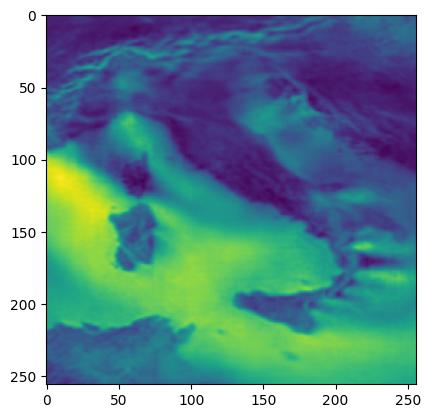

In [41]:
plt.imshow(raw[10,10])

In [26]:
execution_time

28.827590227127075

In [27]:
print("ssim:", ssims.mean(), "  ssim baseline:", ssims_baseline.mean())

print("psnrs:", psnrs.mean(), "  psnrs_baseline:", psnrs_baseline.mean())

print("mse:", mses.mean(), "  mse baseline:", mses_baseline.mean())

ssim: 0.7964766505098788   ssim baseline: 0.7080940925770614
psnrs: 29.48450974430245   psnrs_baseline: 26.36268835909181
mse: 0.0012041098960637352   mse baseline: 0.002566588443630148


In [13]:
print("ssim:", ssims.mean(), "  ssim baseline:", ssims_baseline.mean())

print("psnrs:", psnrs.mean(), "  psnrs_baseline:", psnrs_baseline.mean())

print("mse:", mses.mean(), "  mse baseline:", mses_baseline.mean())

ssim: 0.7976718762530447   ssim baseline: 0.7120680397710939
psnrs: 29.707596118244027   psnrs_baseline: 26.678920945932934
mse: 0.0011494144205628585   mse baseline: 0.002385194862603757


In [14]:
np.save("numerical_results/edsr2020_mses",mses)
#np.save("numerical_results/baseline2020_mses",mses_baseline)

np.save("numerical_results/edsr2020_psnrs",psnrs)
#np.save("numerical_results/baseline2020_psnrs",psnrs_baseline)

np.save("numerical_results/edsr2020_ssims",ssims)
#np.save("numerical_results/baseline2020_ssims",ssims_baseline)

In [24]:
np.random.seed(10)
sampin,sampout = test_generator.__getitem__(1)
tmp = EDSR_model.predict(sampin)

1/1 [==============================] - 0s 442ms/step


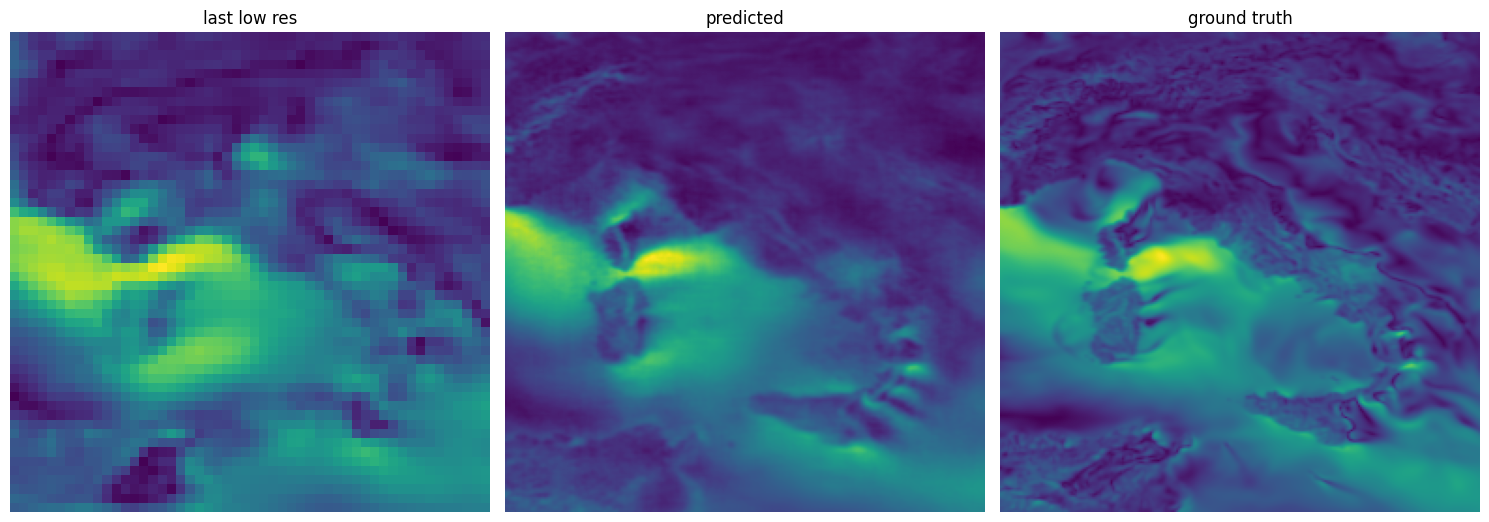

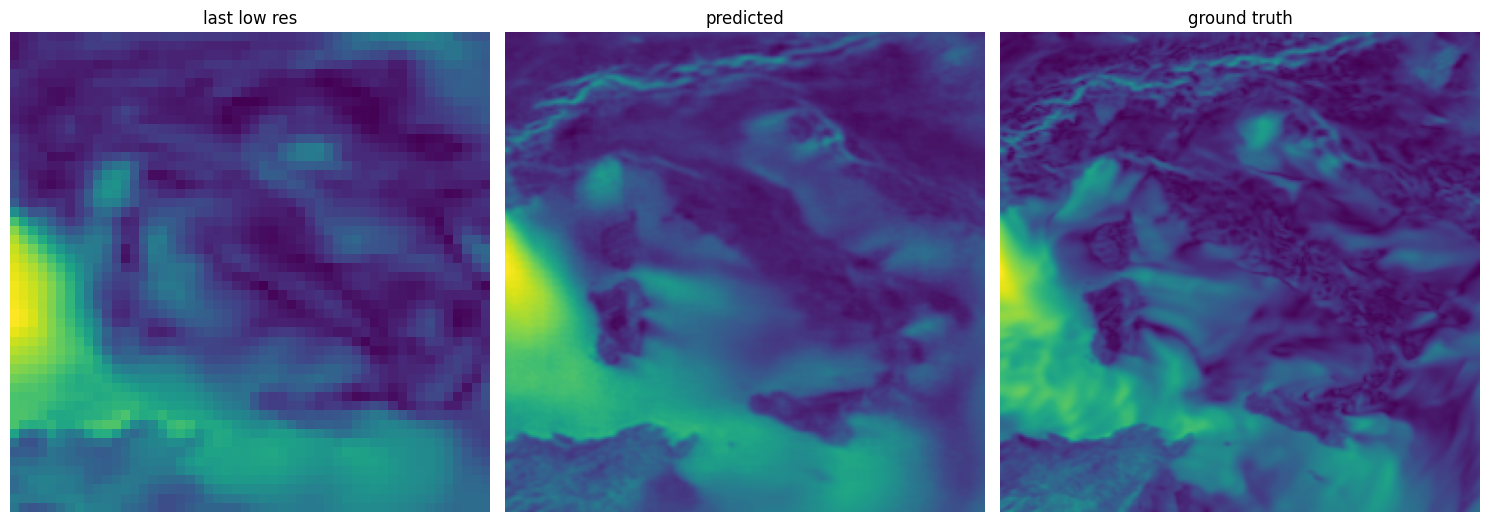

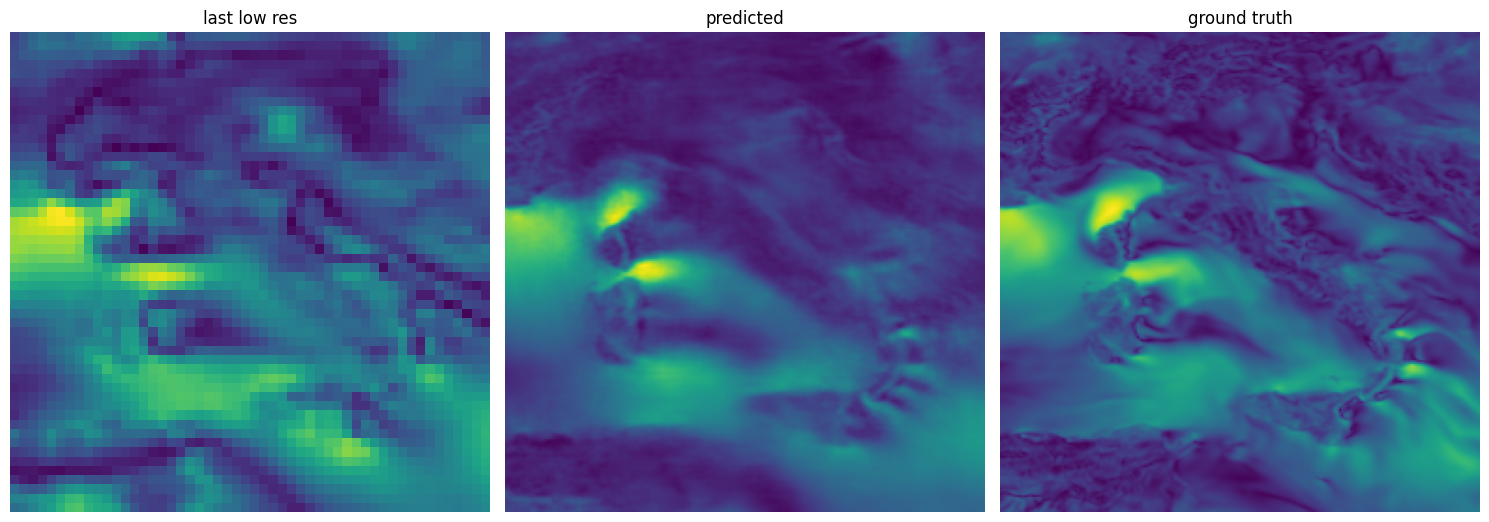

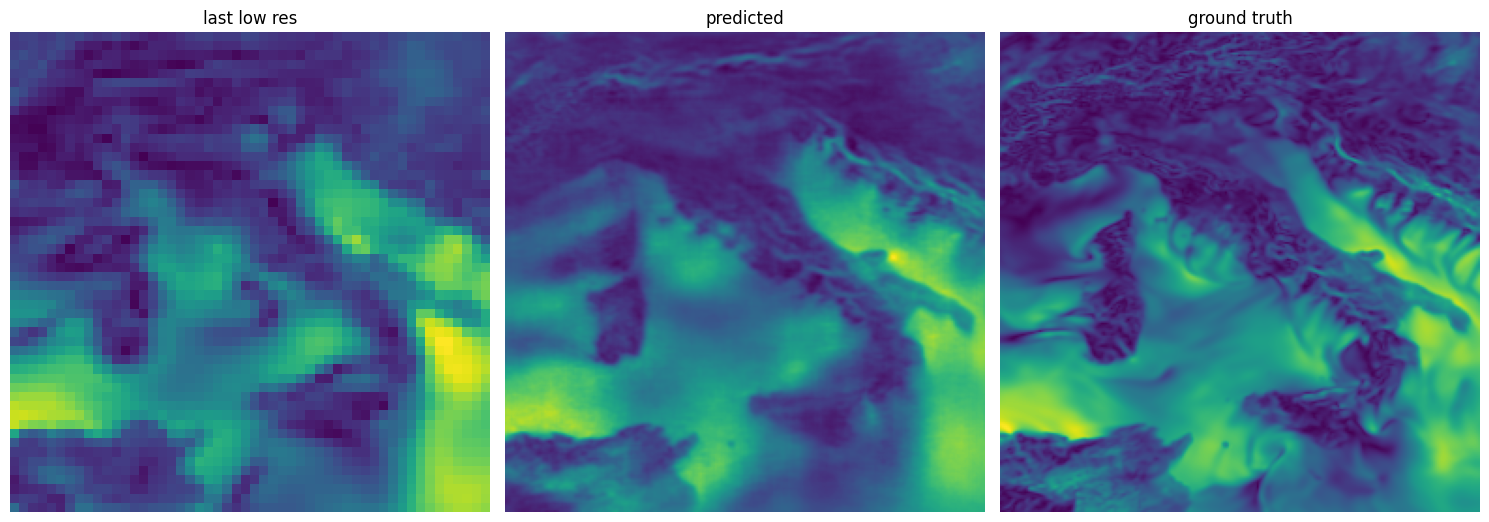

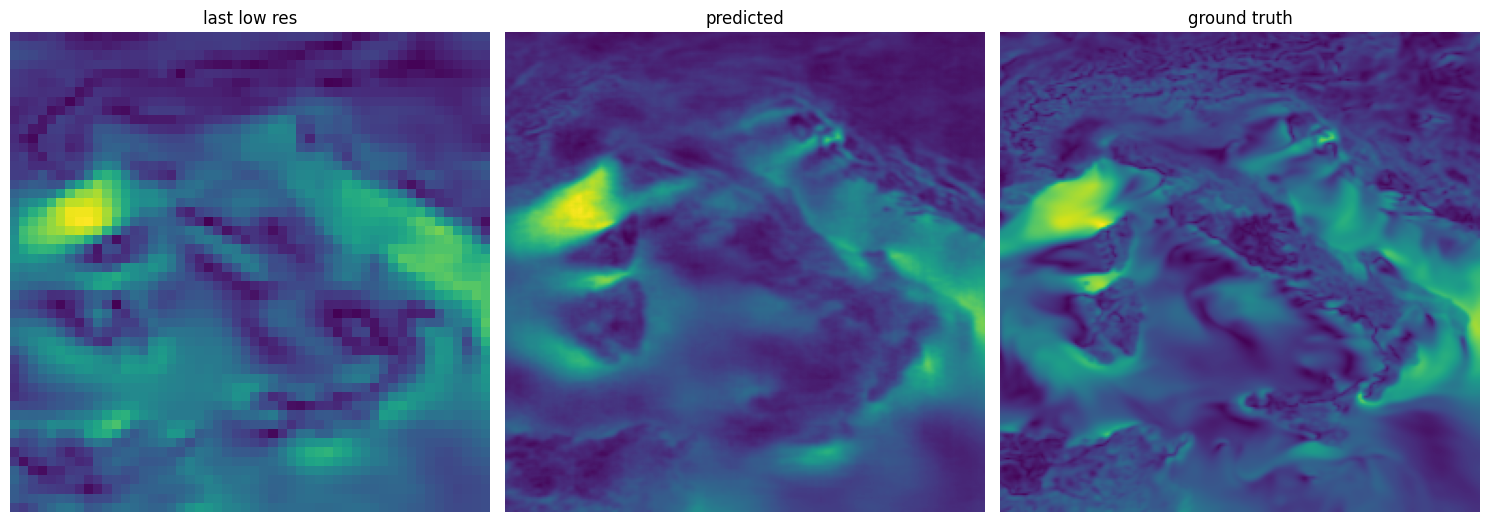

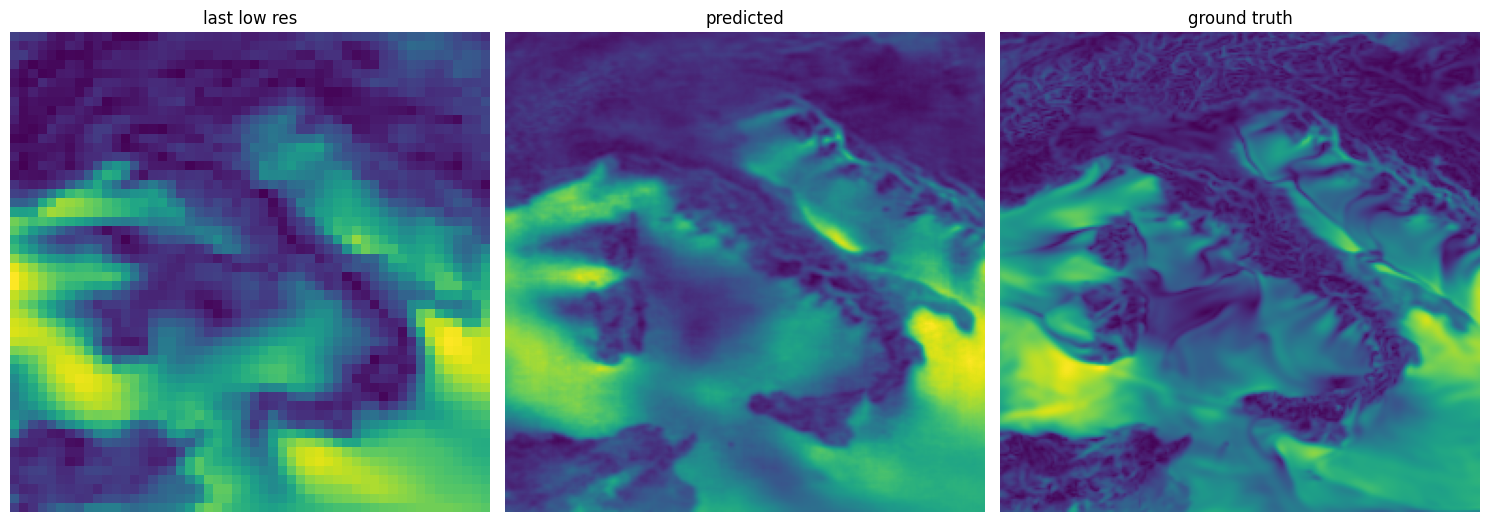

In [25]:
print_results_unet(sampin,sampout,tmp)

In [26]:
#np.save("./visualization_recap_data/edsr",tmp)

## SSIMS maps

In [ ]:
# Experiment
def unet_ssimap_gen(generator, n_iter=100):
    #define final mse array 
    mses = np.zeros(n_iter)
    mses_baseline = np.zeros(n_iter)
    
    maps_log = np.zeros((n_iter, batch_size, 256,256))
    
    ssims = np.zeros(n_iter)
    psnrs = np.zeros(n_iter)
    
    ssims_baseline = np.zeros(n_iter)
    psnrs_baseline = np.zeros(n_iter)
    for i in range(n_iter):
        if(i%5 == 0):
            print(i)
        #select a random batch in the test set  
        sampin,sampout = generator.__getitem__(i)
        
        tmp = unet_model.predict(sampin)
        
        mse = np.mean( ((sampout-np.squeeze(tmp))**2))
        ssims[i], maps = batch_ssim_full(sampout,np.squeeze(tmp))
        psnrs[i] = batch_psnr(sampout,np.squeeze(tmp))
        
        mse_baseline = np.mean( ((sampin[:,:,:,-1]-sampout)**2))
        ssims_baseline[i] = batch_ssim(sampin[:,:,:,-1],sampout)
        psnrs_baseline[i] = batch_psnr(sampin[:,:,:,-1],sampout)
        
        maps_log[i] = maps
        #print(mse.shape)
        # add 3 relevant meteric values to array 
        mses_baseline[i] = mse_baseline
        mses[i] = mse
    # return average of all mses
    return mses, mses_baseline, psnrs, psnrs_baseline, ssims, ssims_baseline, maps_log

In [ ]:
mses, mses_baseline, psnrs, psnrs_baseline, ssims, ssims_baseline, maps = unet_ssimap_gen(test_unet_generator,800)

In [ ]:
maps = maps.reshape(3200,256,256)

In [ ]:
plt.imshow(maps.mean(axis=0))

In [ ]:
plt.imsave("mean ssim map.jpg", maps.mean(axis=0))

## Variance Analyis

In [181]:
def calculate_pixelwise_variance(images):
    # Calculate mean image
    mean_image = np.mean(images, axis=0)

    # Calculate variance
    variance = np.mean([(img - mean_image) ** 2 for img in images], axis=0)
    return variance

In [188]:
def variance_experiment(max_step = 20):
    ensemble_iter = 1
    for k in range(max_step):
        print("working with "+str(k + 1)+" steps")
        full_test_generator.counter_reset()
        variances = []
        mses = []
        ssims = []
        for i in range(10):
            test = full_test_generator.__getitem__(i)
            hist = np.copy(test)
            # define an accumulator variable for ensamble 
            res = np.zeros([batch_size,ensemble_iter, 256,256, 1])
            # run ensamble iterations
            for j in range(ensemble_iter):
                #make a copy of the random batch 
                sample = np.copy(test)

                #normalize sample before generation
                sample = model.normalizer(sample)
                # compute generation with 15 steps 
                tmp = model.generate2(np.copy(sample),k+1)
                #decoded = decoder.predict(tmp[:,:,:,-1], verbose = 0)
                # denormalize prediction
                #tmp = tmp * maxRtesr
                #print(decoded.shape)
                #save prediction in accumulator 
                res[:,j] = tmp[:,:,:,-1:] 
                #print(res.shape)
            variances.append(calculate_pixelwise_variance(res[0,:,:,:,0]).mean())
            average = np.mean(res,axis=1)
            mses.append(np.mean( ((test[:,:,:,-1]-average[:,:,:,-1])**2)))
            ssims.append(batch_ssim(test[:,:,:,-1],average[:,:,:,-1]))
        np.save("nonlinear_variance_studies/single_variance_steps"+str(k+1), variances)
        np.save("nonlinear_variance_studies/single_mses_steps"+str(k+1), mses)
        np.save("nonlinear_variance_studies/single_ssims_steps"+str(k+1), ssims)
            #print(calculate_pixelwise_variance(res[0,:,:,:,0]).mean())
            # average all predictions in the ensamble

In [186]:
def variance_printer(print_range = 3):
    plt.figure(figsize=(14,14))
    for i in range(print_range):
        plt.plot(np.load("nonlinear_variance_studies/single_variance_steps"+str(i+1)+".npy"), label=str(i+1) + " steps")
    plt.title("Ensamble pixelwise variance")    
    plt.legend()
    plt.show()
    plt.figure(figsize=(14,14))
    for i in range(print_range):
        plt.plot(np.load("nonlinear_variance_studies/single_mses_steps"+str(i+1)+".npy"), label=str(i+1) + " steps")
    plt.title("MSES")
    plt.legend()
    plt.show()
    plt.figure(figsize=(14,14))
    for i in range(print_range):
        plt.plot(np.load("nonlinear_variance_studies/single_ssims_steps"+str(i+1)+".npy"), label=str(i+1) + " steps")
    plt.title("SSIMS")
    plt.legend()
    plt.show()

In [184]:
def variance_displayer(print_range = 3):
    variances_mean = []
    mses_mean = []
    ssim_mean = []
    print("VARIANCES")
    for i in range(print_range):
        tmp = np.load("nonlinear_variance_studies/single_variance_steps"+str(i+1)+".npy")
        variances_mean.append(tmp.mean())
    print(variances_mean)
    print("MSES")
    for i in range(print_range):
        tmp = np.load("nonlinear_variance_studies/single_mses_steps"+str(i+1)+".npy")
        mses_mean.append(tmp.mean())
    print(mses_mean)
    print("SSIMS")
    for i in range(print_range):
        tmp = np.load("nonlinear_variance_studies/single_ssims_steps"+str(i+1)+".npy")
        ssim_mean.append(tmp.mean())
    print(ssim_mean)   
    plt.plot(variances_mean,color = "r")
    plt.title("Variance")
    plt.show()
    plt.plot(mses_mean)
    plt.title("MSES")
    plt.show()
    plt.plot(ssim_mean,color = "green")
    plt.title("SSIMS")
    plt.show()

In [189]:
variance_experiment(20)

working with 1 steps
working with 2 steps
working with 3 steps
working with 4 steps
working with 5 steps
working with 6 steps
working with 7 steps
working with 8 steps
working with 9 steps
working with 10 steps
working with 11 steps
working with 12 steps
working with 13 steps
working with 14 steps
working with 15 steps
working with 16 steps
working with 17 steps
working with 18 steps
working with 19 steps
working with 20 steps


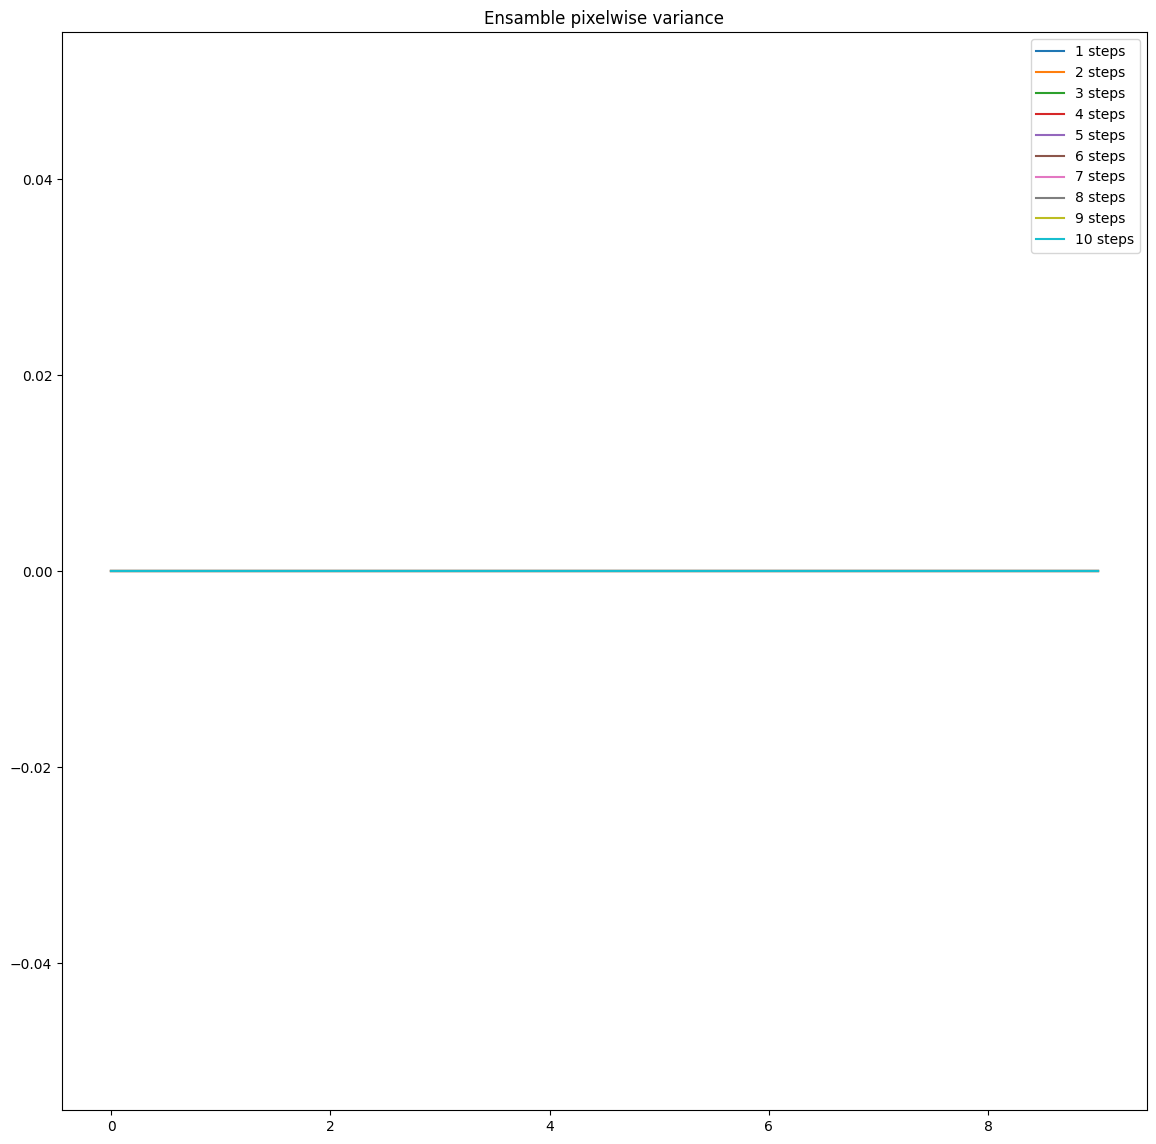

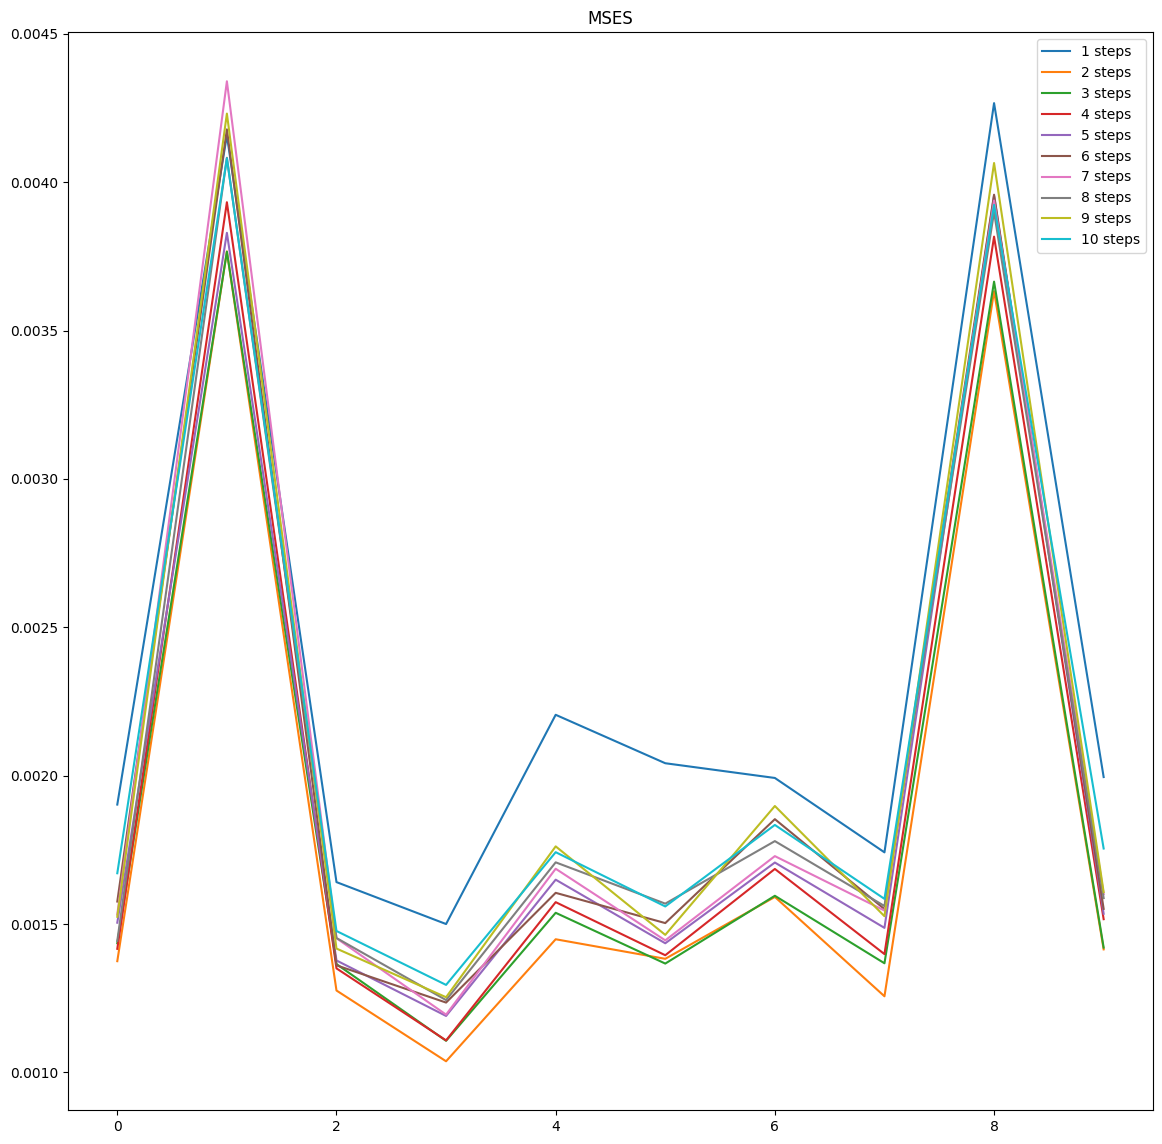

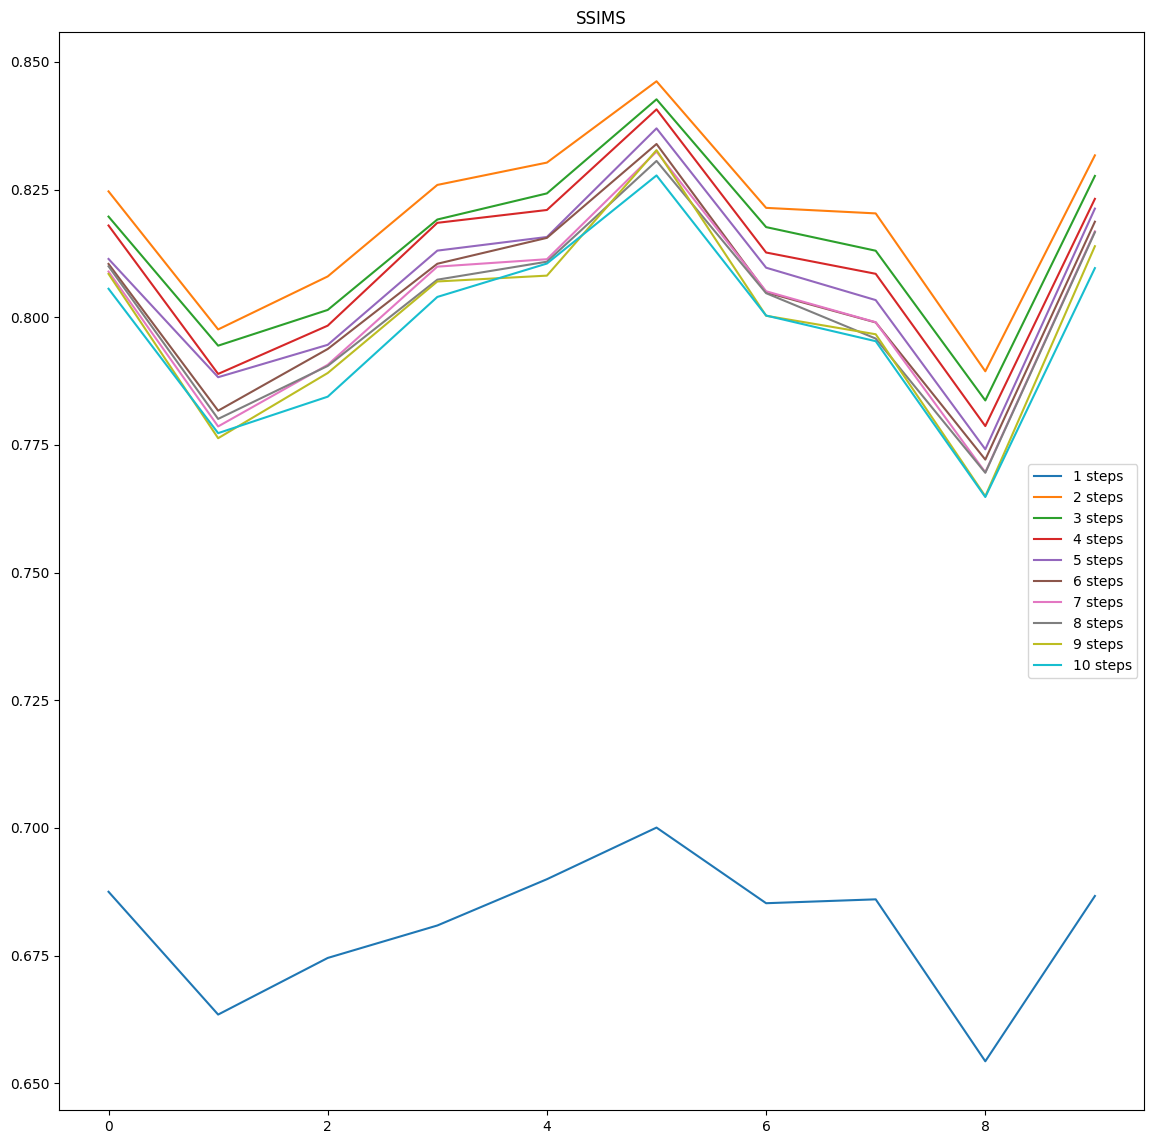

In [190]:
variance_printer(10)

VARIANCES
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
MSES
[0.002344232753293918, 0.0018179209402618228, 0.0018623579225054035, 0.0019190848357186602, 0.001966708948115417, 0.00203687351841935, 0.002046148450341306, 0.0020323479055537716, 0.002074542952468256, 0.0020919005296525977, 0.0021197280037050337, 0.0021290142472447813, 0.002197903775714518, 0.002160757067766924, 0.0021392396586894995, 0.0022222690840840486, 0.002177196624131934, 0.0022619139601014688, 0.002243642061484321, 0.002224934230578136]
SSIMS
[0.6808600587245095, 0.8195524351000103, 0.8143687109126743, 0.8108466897612964, 0.806849205053185, 0.8040561441321813, 0.8022517443677211, 0.8016102096276679, 0.7997575284359328, 0.7979636446162932, 0.7970658675899063, 0.7976393523037026, 0.7949759447847546, 0.7944545494750404, 0.7942896118950167, 0.793996791158881, 0.7941921780588574, 0.7930527051073556, 0.7921474541494844, 0.7920069773887075]


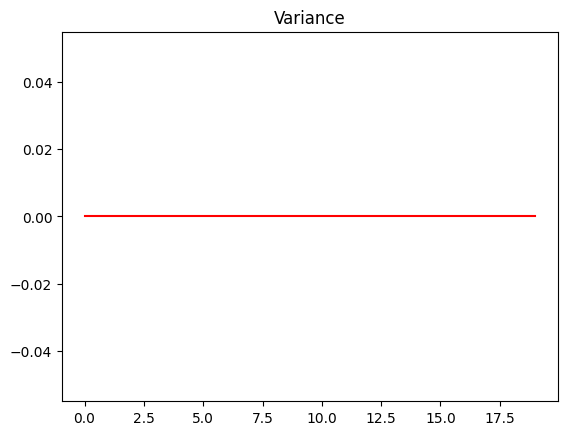

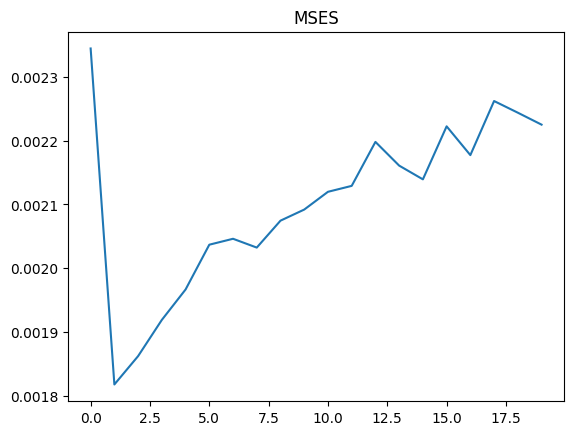

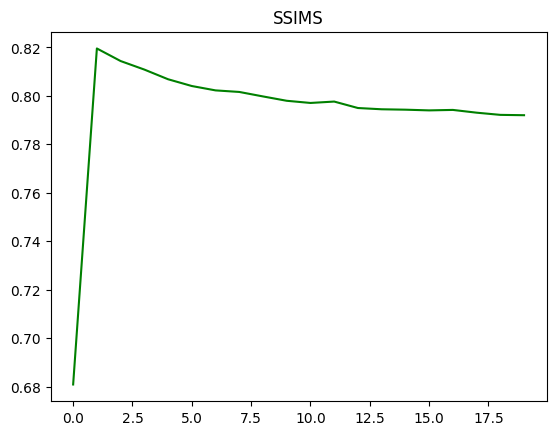

In [191]:
variance_displayer(20)

In [8]:
def variance_printer2(print_range = 3):
    plt.figure(figsize=(14,14))
    for i in range(print_range):
        plt.plot(np.load("correct_variance_studies/variance_steps"+str(i+1)+".npy"), label=str(i+1) + " steps")
    plt.title("Ensamble pixelwise variance")    
    plt.legend()
    plt.show()
    plt.figure(figsize=(14,14))
    for i in range(print_range):
        plt.plot(np.load("correct_variance_studies/mses_steps"+str(i+1)+".npy"), label=str(i+1) + " steps")
    plt.title("MSES")
    plt.legend()
    plt.show()
    plt.figure(figsize=(14,14))
    for i in range(print_range):
        plt.plot(np.load("correct_variance_studies/ssims_steps"+str(i+1)+".npy"), label=str(i+1) + " steps")
    plt.title("SSIMS")
    plt.legend()
    plt.show()

In [9]:
def variance_displayer2(print_range = 3):
    variances_mean = []
    mses_mean = []
    ssim_mean = []
    print("VARIANCES")
    for i in range(print_range):
        tmp = np.load("correct_variance_studies/variance_steps"+str(i+1)+".npy")
        variances_mean.append(tmp.mean())
    print(variances_mean)
    print("MSES")
    for i in range(print_range):
        tmp = np.load("correct_variance_studies/mses_steps"+str(i+1)+".npy")
        mses_mean.append(tmp.mean())
    print(mses_mean)
    print("SSIMS")
    for i in range(print_range):
        tmp = np.load("correct_variance_studies/ssims_steps"+str(i+1)+".npy")
        ssim_mean.append(tmp.mean())
    print(ssim_mean)   
    plt.plot(variances_mean,color = "r")
    plt.title("Variance")
    plt.show()
    plt.plot(mses_mean)
    plt.title("MSES")
    plt.show()
    plt.plot(ssim_mean,color = "green")
    plt.title("SSIMS")
    plt.show()

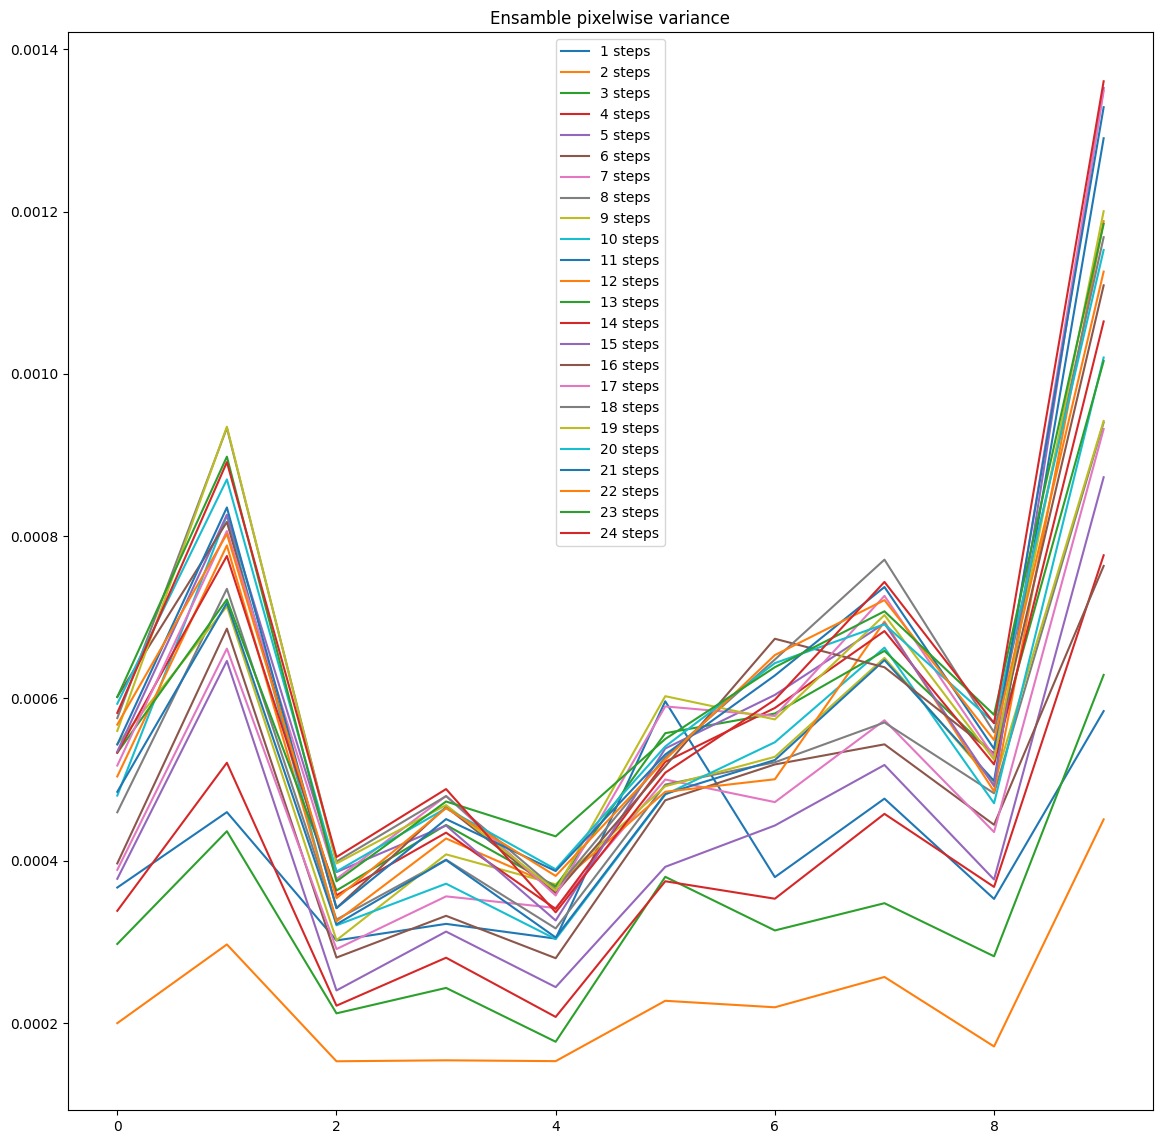

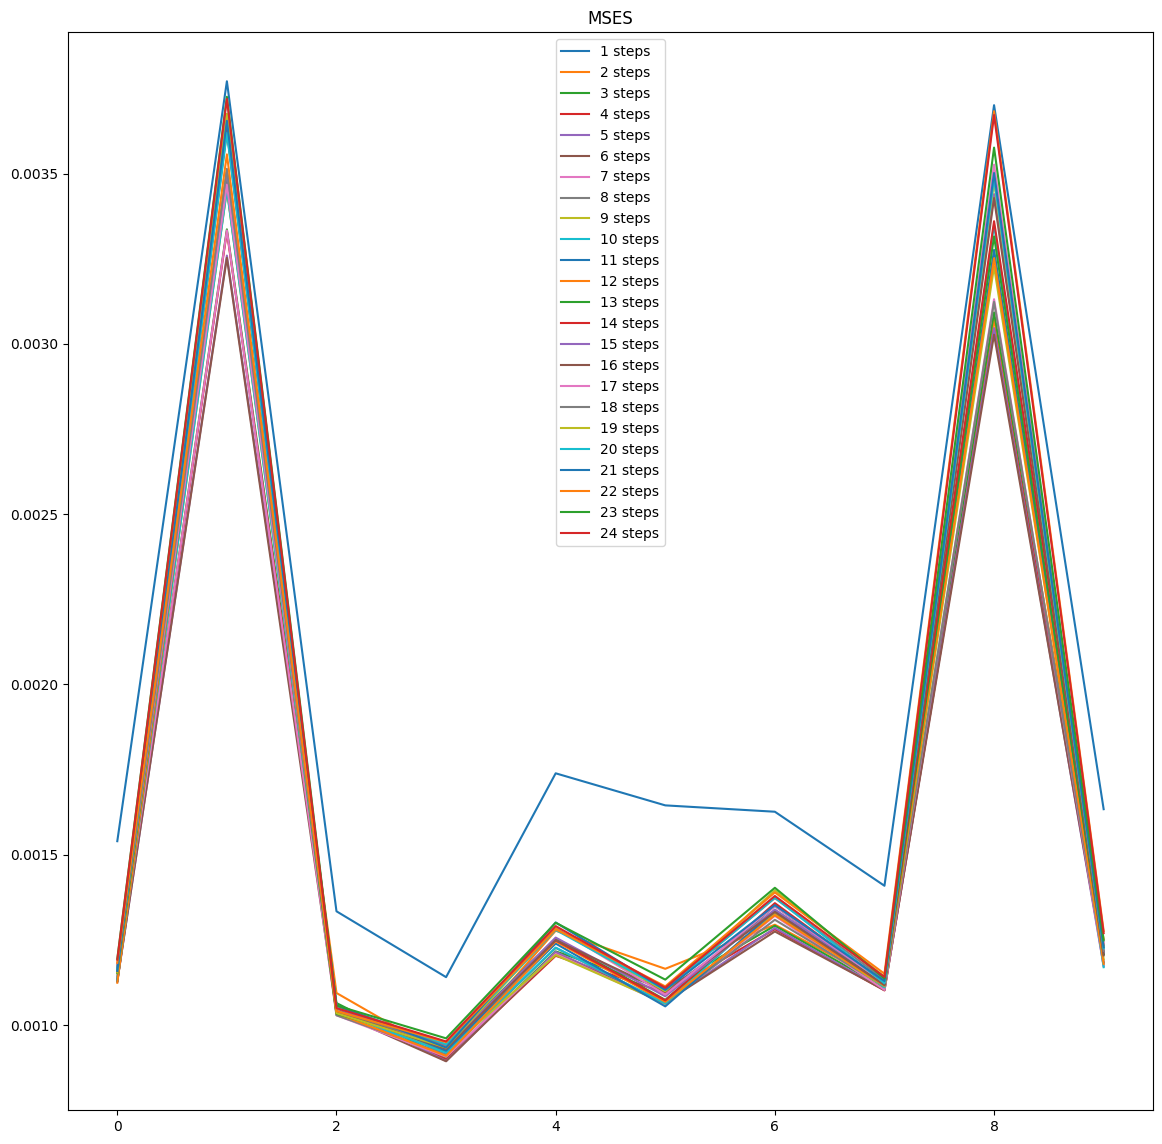

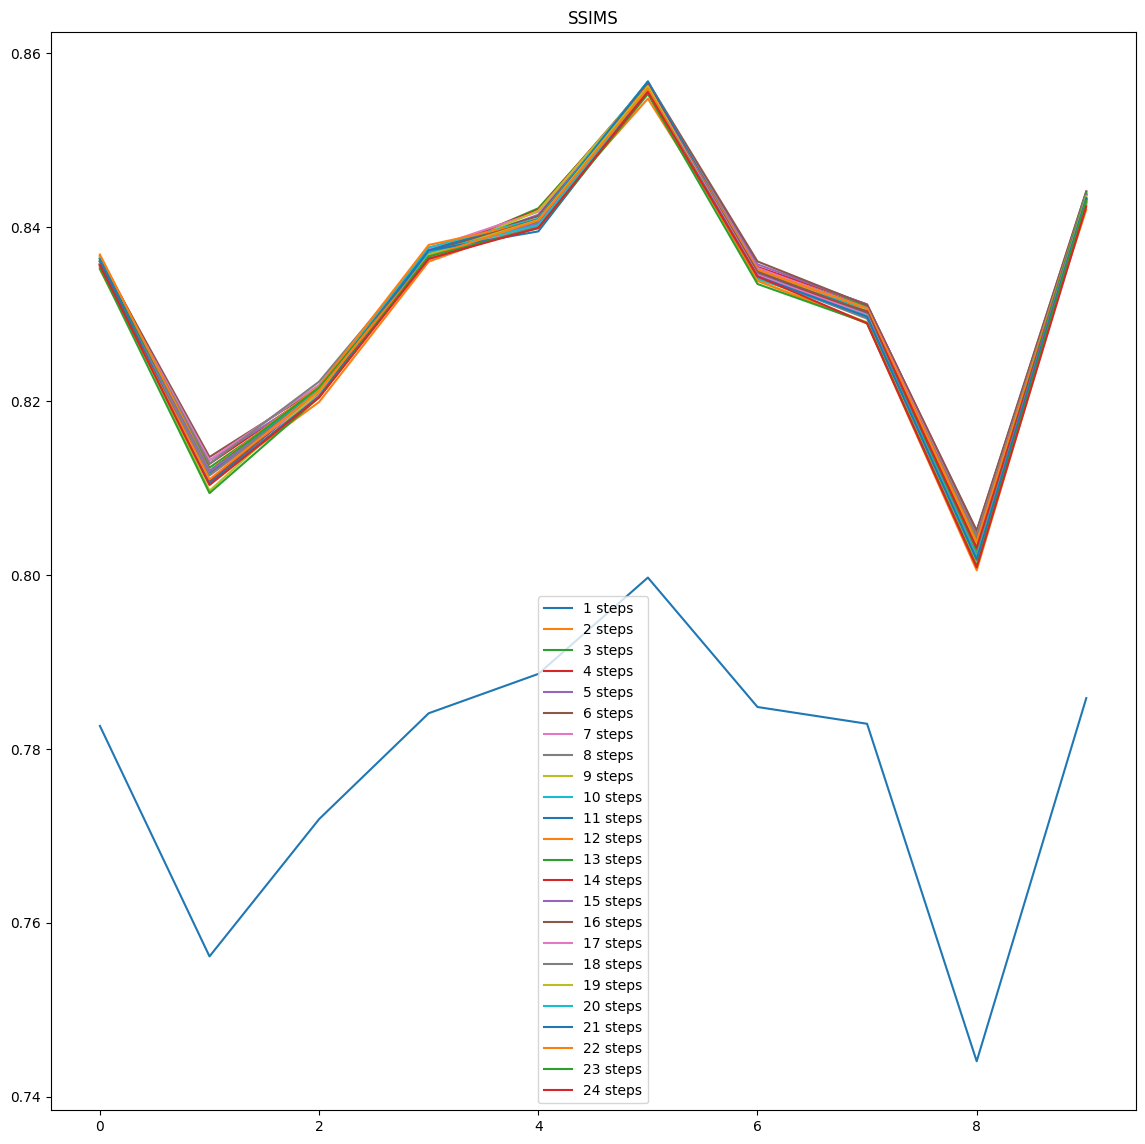

In [10]:
variance_printer2(24)

VARIANCES
[0.0004145389386215126, 0.00022826324257941804, 0.0003319485756641882, 0.00038985993045542717, 0.00044248712659367714, 0.00047198755542458544, 0.0004952457154392997, 0.0005249313252549384, 0.0005445409796394494, 0.0005482874798101757, 0.0005673304247513516, 0.0005767431807498664, 0.0005774871252614669, 0.0005818144224254244, 0.0006196353535218822, 0.0006057915500063674, 0.0006310203106024536, 0.0006426086720699526, 0.0006328466857649229, 0.0006303158849483423, 0.0006322185962503753, 0.0006144686267845534, 0.0006438291593648893, 0.0006483680534937073]
MSES
[0.001953941472421337, 0.0015817832792835245, 0.0015470235004274868, 0.001535027643708935, 0.0015227734327587805, 0.0015175772173992871, 0.0015408343313879718, 0.0015562397437600298, 0.0015671249214607125, 0.0015815785088526622, 0.001583324325568154, 0.001575618252613243, 0.0015951619488194784, 0.0016159997515893597, 0.0016116277502814206, 0.0016181210614468438, 0.0016257958246093899, 0.0016262906352716828, 0.001642477075947

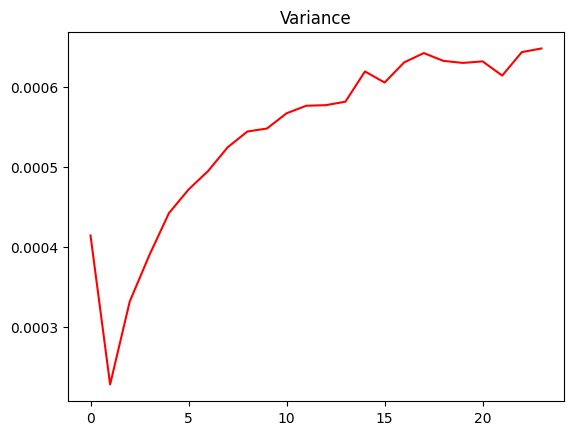

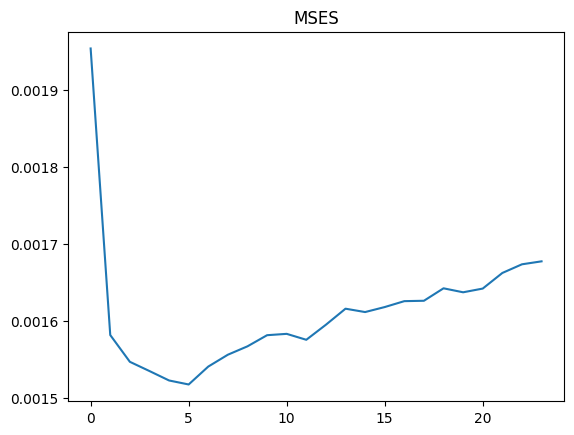

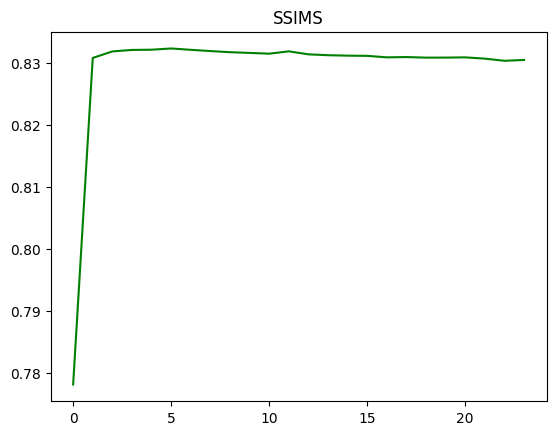

In [11]:
variance_displayer2(24)

## Extras

In [ ]:
def plot_sequence(data, start_idx=0, num_imgs=5):
    fig, axes = plt.subplots(1, num_imgs, figsize=(15, 3))
    
    for i in range(num_imgs):
        ax = axes[i]
        ax.imshow(data[start_idx + i], cmap='viridis')  # Use appropriate colormap for your data
        ax.axis('off')
        ax.set_title(f"Index {start_idx + i}")

    plt.tight_layout()
    plt.show()

# Plotting 5 contiguous images starting from index 10 (for example)
plot_sequence(high_res_dataset, start_idx=33, num_imgs=5)
plot_sequence(low_res_dataset, start_idx=33, num_imgs=5)